<!-- ## IoT for Eco-Friendly Tourism - Summer School
### Valencia, Spain - 2025 -->
![alt text](remarkable.png)
-------

### ML-based model compression 

#### Libraries

In [66]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist

from distillationClassKeras import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Enable GPU 

In [67]:
# GPU
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  0


#### Load dataset

In [68]:
# Cargar dataset MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0            # Normalización

In [69]:
# x_train = x_train.reshape(-1, 28 * 28)                       # Aplanar imágenes
# x_test = x_test.reshape(-1, 28 * 28)

In [70]:
# Create binary labels: even digits (0, 2, 4, 6, 8) as 1, and odd digits (1, 3, 5, 7, 9) as 0
# y_train_binary = np.isin(y_train, [0, 2, 4, 6, 8]).astype(int)
# y_test_binary = np.isin(y_test, [0, 2, 4, 6, 8]).astype(int)

##### Label selection for the binary classification

Filter images that only contain numbers 1 and 9


In [71]:
train_filter = np.where((y_train == 1) | (y_train == 9))
test_filter = np.where((y_test == 1) | (y_test == 9))

x_train = x_train[train_filter]
y_train = y_train[train_filter]
x_test = x_test[test_filter]
y_test = y_test[test_filter]

In [72]:
# Convertir las etiquetas a binario: 1 -> [1, 0], 7 -> [0, 1]
y_train_binary = np.where(y_train == 1, 0, 1)  # 1 -> 0, 9 -> 1
y_test_binary = np.where(y_test == 1, 0, 1)  # 1 -> 0, 9 -> 1

In [73]:
# One-hot Encoding
y_train_binary = to_categorical(y_train_binary, num_classes=2, dtype=int)
y_test_binary = to_categorical(y_test_binary, num_classes=2, dtype=int)

### Student model definition

The student architecture is defined in a quantized manner.

In [74]:

def build_student():
    # Fixed point precision
    kernelQ = "quantized_bits(8,3,alpha=1)"
    biasQ = "quantized_bits(8, 3,alpha=1)"
    activationQ = 'quantized_bits(16,6)'

    modelQ = Sequential(
                [   
                    
                    QDense(5, name='fc1_input',
                            input_shape=(28 * 28,),
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    QActivation(activation= activationQ ,  name='relu_input'),

                    QDense(7, name='fc1',
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    QActivation(activation= activationQ ,  name='relu1'),

                    QDense(10, name='fc2',
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    QActivation(activation= activationQ ,  name='relu2'),
                    
                    QDense(2, name='output',
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    Activation(activation='sigmoid', name='sigmoid')
                
                ],

            )
    return modelQ



In [75]:
x_train = x_train.reshape(x_train.shape[0], 28 * 28)
x_test = x_test.reshape(x_test.shape[0], 28 * 28)

### Teacher model

Teacher model defined in 32-bit floating-point

In [76]:

def build_teacher():
    model = keras.Sequential([
        Dense(7, activation="relu", input_shape=(28 * 28,)),
        Dense(5, activation="relu"),
        Dense(10, activation="relu"),
        Dropout(0.2),
        Dense(2, activation="sigmoid")  
    ])
    return model




### Teacher model: compile and fit

In [77]:
teacher = build_teacher()
teacher.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 7)                 5495      
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 40        
_________________________________________________________________
dense_14 (Dense)             (None, 10)                60        
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 22        
Total params: 5,617
Trainable params: 5,617
Non-trainable params: 0
_________________________________________________________________


In [78]:
lr = 0.0001
op = Adam(lr)
loss = "categorical_crossentropy"
metrics = ["accuracy"]
epochs=16
batch_size=128

teacher.compile(optimizer=op, loss=loss, metrics=metrics)
h = teacher.fit(x_train, y_train_binary, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_binary))

Epoch 1/16
100/100 [==============================] - 0s 2ms/step - loss: 0.6670 - accuracy: 0.6242 - val_loss: 0.5707 - val_accuracy: 0.9338
Epoch 2/16
100/100 [==============================] - 0s 805us/step - loss: 0.5378 - accuracy: 0.8879 - val_loss: 0.4091 - val_accuracy: 0.9823
Epoch 3/16
100/100 [==============================] - 0s 797us/step - loss: 0.3915 - accuracy: 0.9420 - val_loss: 0.2608 - val_accuracy: 0.9879
Epoch 4/16
100/100 [==============================] - 0s 807us/step - loss: 0.2687 - accuracy: 0.9593 - val_loss: 0.1651 - val_accuracy: 0.9907
Epoch 5/16
100/100 [==============================] - 0s 805us/step - loss: 0.1912 - accuracy: 0.9647 - val_loss: 0.1074 - val_accuracy: 0.9916
Epoch 6/16
100/100 [==============================] - 0s 793us/step - loss: 0.1444 - accuracy: 0.9684 - val_loss: 0.0738 - val_accuracy: 0.9921
Epoch 7/16
100/100 [==============================] - 0s 822us/step - loss: 0.1117 - accuracy: 0.9705 - val_loss: 0.0535 - val_accuracy: 0

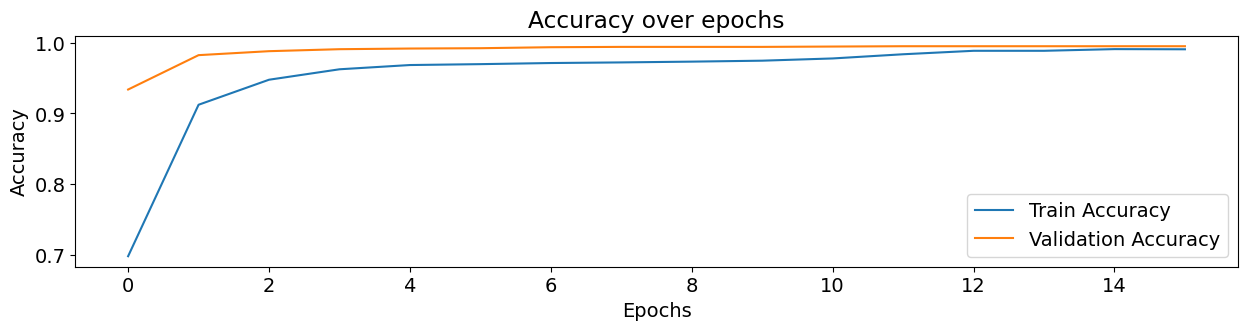

In [79]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(h.history['accuracy'], label='Train Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

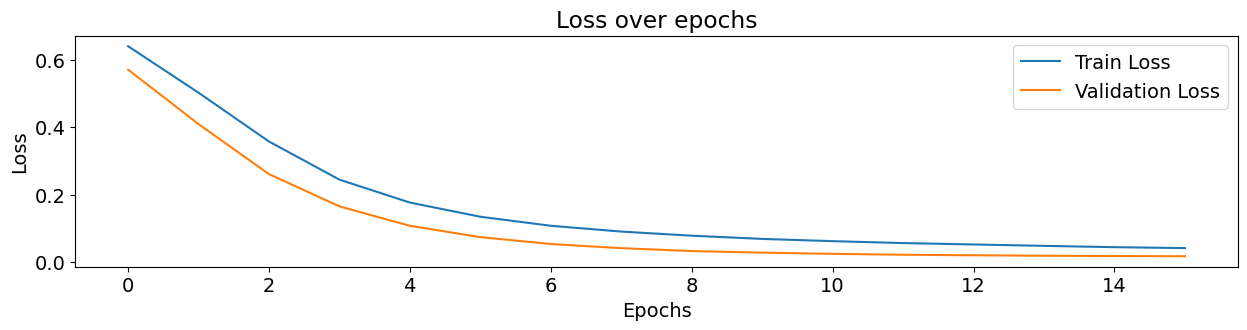

In [80]:
# Plot loss over epochs
plt.figure(figsize=(15,3))
plt.plot(h.history['loss'], label='Train Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()


### Confusion matrix

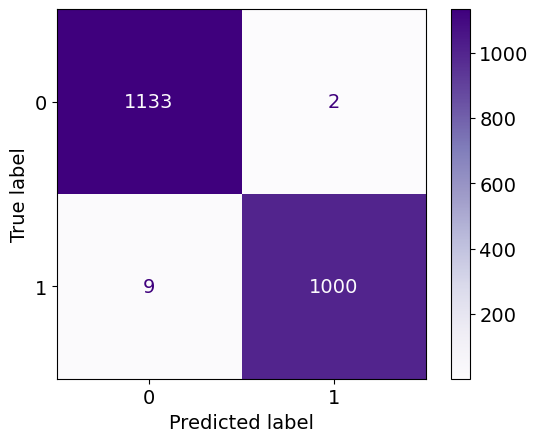

In [81]:
y_pred_probs = teacher.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test_binary, axis=1)  # Convert one-hot encoded labels to class indices


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.show()


### Build student model

In [82]:
modelQ = build_student()

In [83]:
modelQ.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1_input (QDense)           (None, 5)                 3925      
_________________________________________________________________
relu_input (QActivation)     (None, 5)                 0         
_________________________________________________________________
fc1 (QDense)                 (None, 7)                 42        
_________________________________________________________________
relu1 (QActivation)          (None, 7)                 0         
_________________________________________________________________
fc2 (QDense)                 (None, 10)                80        
_________________________________________________________________
relu2 (QActivation)          (None, 10)                0         
_________________________________________________________________
output (QDense)              (None, 2)                

### Pruning strategy

In [84]:
final_sparsity = 0.2

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=3000
                )
            }

model_QPKD = tfmot.sparsity.keras.prune_low_magnitude(modelQ, **pruning_params)

/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [85]:
lr = 0.00001
op = Adam(lr)
loss = "categorical_crossentropy"
metrics = ["accuracy"]
epochs=32
batch_size=128

model_QPKD.compile(optimizer=op, loss=loss, metrics=metrics)
h = model_QPKD.fit(x_train, y_train_binary, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_binary),callbacks = [tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/32
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (

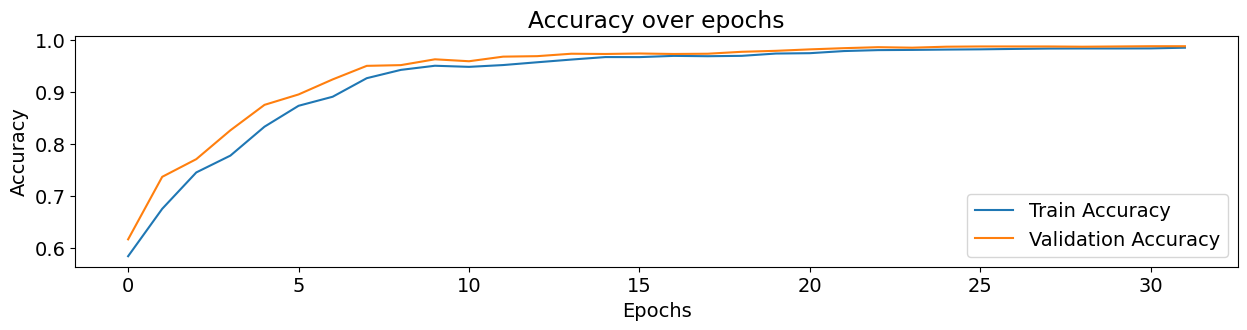

In [86]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(h.history['accuracy'], label='Train Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

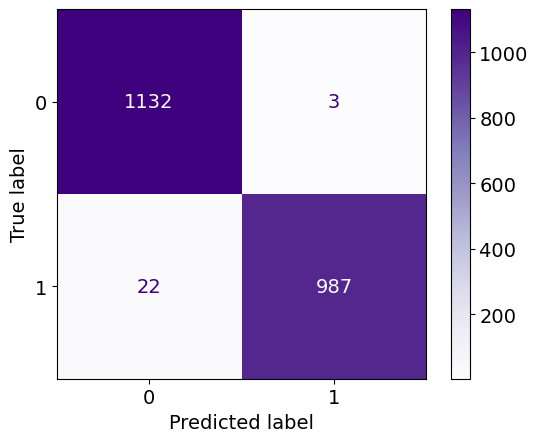

In [87]:
plt.rcParams.update({'font.size': 14})

y_pred_probs = model_QPKD.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test_binary, axis=1)  # Convert one-hot encoded labels to class indices


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.show()


In [88]:
model_KD = strip_pruning(model_QPKD)
model_KD.save("models/mnistPQKD.h5")

### Knowledge distillation implementation

In [ ]:
y_train_binary = y_train_binary.reshape(-1, 1)  # Shape (num_samples, 1)
y_test_binary = y_test_binary.reshape(-1, 1)  # Shape (num_samples, 1)

In [ ]:
# train_labels = np.argmax(y_train_binary, axis=1)

distilledMLP = Distiller(student=model_QPKD, teacher=teacher)

op = Adam(0.0001)
distilledMLP.compile(
        optimizer= op,
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1, 
        temperature=10,
    )

history = distilledMLP.fit(x_train, y_train_binary, validation_split=0.2, batch_size = 32, epochs= 16, callbacks = [tfmot.sparsity.keras.UpdatePruningStep()])

In [ ]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

#### Confusion matrix

In [ ]:
y_pred_probs = distilledMLP.student.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.show()


In [ ]:
model_KD = strip_pruning(distilledMLP.student)
model_KD.save("models/mnistPQKD.h5")

---
#### Valencia, Spain - 2025

Romina Soledad Molina, Ph.D. - MLab/STI ICTP, Trieste, Italy